In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### GOAL:

Compare simulated 2pcf results (Illustris TNG300) to the results predicted by linear theory (Colossus).

$\rightarrow$ at different redshifts and stellar mass cutoffs

In [2]:
# key directories
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
import illustris_python as il
from Corrfunc.theory.xi import xi
import os
import sys
sys.path.insert(0, work)
from corrfunc_ls import compute_3D_ls_auto
from illustris_sim import IllustrisSim
import tools

#### parameters for both Colossus and Illustris

In [4]:
redshifts = [20.05, 10., 5., 0.]
# load in computed xi from Illustris
il_results = {}
for redshift in redshifts:
    result = np.load(os.path.join(scratch, f'xi/xi_dm_TNG300-3_z-{redshift:.2f}_nx-100.npy'), allow_pickle=True)
    il_results[redshift] = result.item()

In [5]:
res = il_results[0]
ravg, rmin, rmax, nbins = res['ravg'], res['rmin'], res['rmax'], res['nbins']
rmin, rmax, nbins

(0.1, 50.0, 20)

In [6]:
# color map
cmap = mpl.colormaps['cool']
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

### Illustris 2pcf

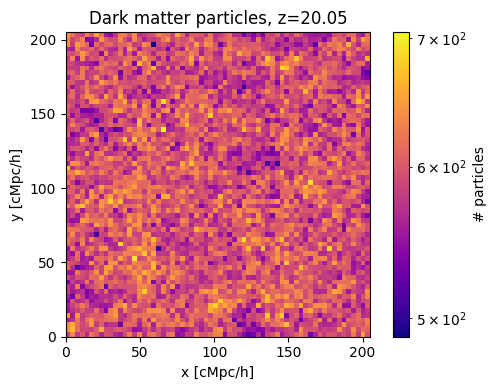

In [7]:
# check out one data set
z = 20.05
dm_pos = il_results[z]['dm_pos']
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_pos[:,0], dm_pos[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title(f'Dark matter particles, z={z}')
fig.tight_layout()

### Colossus 2pcf

In [8]:
# set cosmology: same as used by Illustris, Planck 2015
cosmo_model = 'planck15'
cosmo = cosmology.setCosmology(cosmo_model, persistence='r')  # persistence='r' sets this to read-only

** We assume that the linear over- and underdensity field is given by a Gaussian random field which is unambiguously described by its power spectrum $P(k)$.

In [9]:
# matter power spectrum
k = np.logspace(-5.0, 2.0, 500)
Pk = cosmo.matterPowerSpectrum(k)  # defaults to the approximation of Eisenstein & Hu 1998

In [10]:
# 2-pt. matter-matter correlation function is an integral over the power spectrum:
xi_cols = [cosmo.correlationFunction(ravg, z=redshift) for redshift in redshifts]

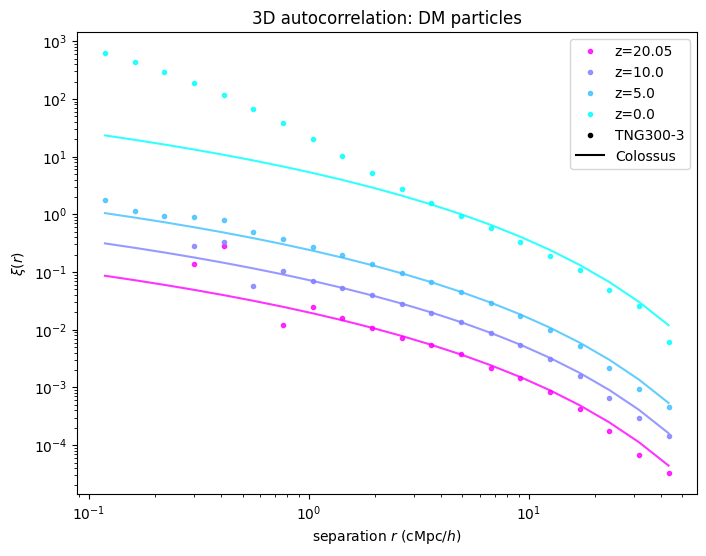

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

for i, redshift in enumerate(redshifts):
    ravg, xi_il = il_results[redshift]['ravg'], il_results[redshift]['xi']
    ax.plot(ravg, xi_il, c=smap.to_rgba(redshift), marker='.', ls='None', alpha=0.8, label=f'z={redshift}')
    ax.plot(ravg, xi_cols[i], c=smap.to_rgba(redshift), alpha=0.8)

# labels for TNG vs Colossus
point = mpl.lines.Line2D([0], [0], label='TNG300-3', marker='.', color='k', ls='None')
line = mpl.lines.Line2D([0], [0], label='Colossus', color='k')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([point, line])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\xi (r)$')
ax.set_title(r'3D autocorrelation: DM particles')
ax.legend(handles=handles)